# Distracted Driver Detection

## Include Dependency

In [ ]:
# Import TensorFlow and set GPU device
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import glob
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

import math
import random

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import log_loss

import h5py


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

# Get the list of available physical devices (CPU and GPU)
physical_devices = tf.config.list_physical_devices()

if len(physical_devices) == 0:
    print("No GPU devices found.")
else:
    # Print information about each physical device
    for device in physical_devices:
        print(f"Device name: {device.name}, Device type: {device.device_type}")


Device name: /physical_device:CPU:0, Device type: CPU
Device name: /physical_device:GPU:0, Device type: GPU


## Data Exploratory

## Data Preprocessing

When we import the dataset, we need to resize the orignal image first, here is the example:

We want all image to be substracted by the mean value, the example is shown below:

## Create training input

Load the data and resize to create training set.

In [ ]:
X_train = []
y_train = []

for i in range(5):
    path = os.path.join( '/content/drive/MyDrive/dataset/second/databoom/imgs/train/c' + str(i), '*.jpg')
    files = glob.glob(path)
    for fl in files:
        img = cv2.imread(fl)
        img = cv2.resize(img, (224, 224), cv2.INTER_LINEAR)
        X_train.append(img)
        y_train.append(i)

In [ ]:
X_train = np.array(X_train, dtype=np.uint8)
y_train = np.array(y_train, dtype=np.uint8)

In [ ]:
X_train = X_train.astype('float16')
y_train = to_categorical(y_train, 5)

In [ ]:
mean = [103.939, 116.779, 123.68]
X_train = X_train.astype('float32')  # Convert to float32

X_train[:, :, :, 0] -= mean[0]
X_train[:, :, :, 1] -= mean[1]
X_train[:, :, :, 2] -= mean[2]


print('the shape of training set: ', X_train.shape)

the shape of training set:  (7933, 224, 224, 3)


In [ ]:
pip install matplotlib


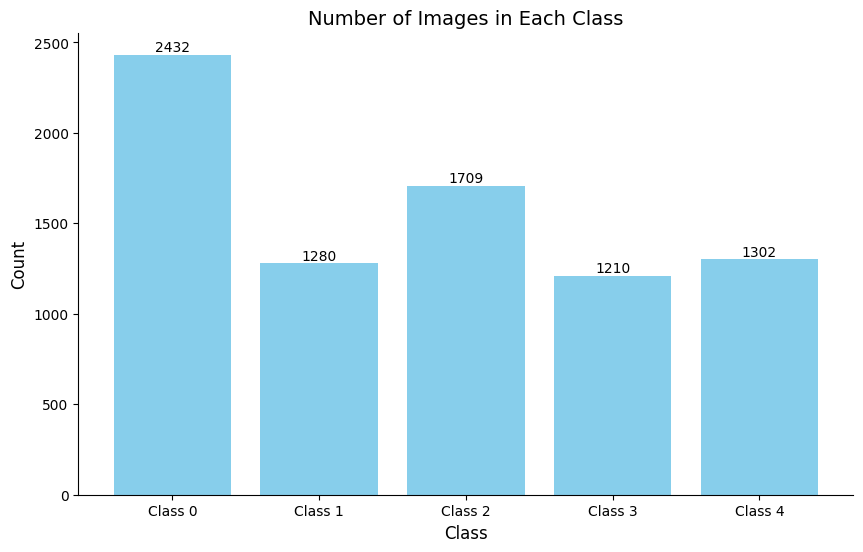

In [ ]:
import os
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already loaded your data into X_train and y_train

# Count the number of images in each folder
class_counts = {}

data_folder = '/content/drive/MyDrive/dataset/second/databoom/imgs/train/'

for i in range(5):
    folder_path = os.path.join(data_folder, f'c{i}')
    file_count = len(glob.glob(os.path.join(folder_path, '*.jpg')))
    class_counts[f'Class {i}'] = file_count

# Create a bar plot with improved styling
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(class_counts.keys(), class_counts.values(), color='skyblue')

# Add data labels on top of the bars
for bar, count in zip(bars, class_counts.values()):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.05, f'{count}', ha='center', va='bottom', fontsize=10, color='black')

# Add labels and title
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Number of Images in Each Class', fontsize=14)

# Customize the appearance
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))  # Format y-axis ticks as integers

# Show the plot
plt.show()


## Training Model Design

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Check if GPU is available
if tf.test.gpu_device_name():
    print('GPU available')
else:
    print('GPU not available')

# Build the non-pretrained CNN model
def build_non_pretrained_cnn(input_shape=(224, 224, 3), num_classes=5):
    model = Sequential()

    # Convolutional layer with 32 filters, a 3x3 kernel, and ReLU activation
    model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu'))
    # Max pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional layer with 64 filters, a 3x3 kernel, and ReLU activation
    model.add(Conv2D(64, (3, 3), activation='relu'))
    # Max pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional layer with 128 filters, a 3x3 kernel, and ReLU activation
    model.add(Conv2D(128, (3, 3), activation='relu'))
    # Max pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten layer to transition from convolutional layers to fully connected layers
    model.add(Flatten())

    # Fully connected layer with 256 neurons and ReLU activation
    model.add(Dense(256, activation='relu'))

    # Output layer with softmax activation for classification
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model with an optimizer, loss function, and metric
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the non-pretrained CNN model
non_pretrained_cnn_model = build_non_pretrained_cnn()
non_pretrained_cnn_model.summary()


GPU available
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26

## Train Model and Save

In [ ]:
import tensorflow as tf

# Get the list of physical devices (GPUs)
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    # Set memory growth for each GPU
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    print("No GPU devices found.")

In [ ]:

foldn = 0
n_folds = 5
log_list = []

np.random.seed(2016)
kf = KFold(n_splits=n_folds, shuffle=True, random_state=51)

for train, test in kf.split(X_train):
    foldn += 1

    print('number {} fold of {} folds cross-validation'.format(foldn, n_folds))
    print('Split into training and validation set', len(train), len(test))

    model = build_non_pretrained_cnn()  # Ensure train_model() includes model architecture and compilation

    weights_path = os.path.join('dataset', 'second','databoom','weig' + str(foldn) + '.h5')

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0),
        ModelCheckpoint(weights_path, monitor='val_loss', save_best_only=True, verbose=1, mode='auto'),
    ]

    log = model.fit(X_train[train], y_train[train], batch_size=16, epochs=10, shuffle=True, verbose=1, validation_data=(X_train[test], y_train[test]), callbacks=callbacks)


    log_list.append(log)

    # Assuming 'acc' is the old key for accuracy
    # Change 'acc' to 'accuracy' for training accuracy and 'val_acc' to 'val_accuracy' for validation accuracy

    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(log.history['loss'], label='train')
    plt.plot(log.history['val_loss'], label='val')
    plt.title('Model Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(log.history['accuracy'], label='train')  # Change 'acc' to 'accuracy'
    plt.plot(log.history['val_accuracy'], label='val')  # Change 'val_acc' to 'val_accuracy'
    plt.title('Model Accuracy')
    plt.legend()

    plt.show()



number 1 fold of 5 folds cross-validation
Split into training and validation set 6346 1587


In [ ]:
import cv2
import os

def split_video_into_frames(video_path, output_folder):
    # Open the video file
    video_capture = cv2.VideoCapture(video_path)

    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Initialize frame counter
    frame_count = 0

    while True:
        # Read a frame from the video
        success, frame = video_capture.read()

        # Break the loop if we have reached the end of the video
        if not success:
            break

        # Save the frame to the output folder
        frame_filename = os.path.join(output_folder, f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(frame_filename, frame)

        # Increment frame counter
        frame_count += 1

    # Release the video capture object
    video_capture.release()

if __name__ == "__main__":
    # Specify the path to the input video
    video_path = "/content/drive/MyDrive/dataset/second/databoom/ccc.mp4"

    # Specify the output folder for frames
    output_folder = "/content/drive/MyDrive/dataset/second/databoom"

    # Call the function to split video into frames
    split_video_into_frames(video_path, output_folder)


KeyboardInterrupt: ignored

In [ ]:

if __name__ == "__main__":
    # Specify the path to the input video
    video_path = "/content/drive/MyDrive/dataset/second/databoom/ccc.mp4"

    # Specify the output folder for frames
    output_folder = "/content/drive/MyDrive/dataset/second/databoom/tsawer"

    # Call the function to split video into frames
    split_video_into_frames(video_path, output_folder)

## Save Model

In [ ]:
with open('/content/drive/MyDrive/dataset/second/databoom/imgs/model.json', 'w') as f:
    f.write(model.to_json())

## Create Submission

In [ ]:
batch_size = 32
fold_n = 0
y_test_all = []
nfolds=5

In [ ]:
def train_model():
    # Define and compile your model architecture
    model = build_non_pretrained_cnn()  # Assuming this is the same model as in the training loop

    # Load the weights
    weights_path = os.path.join('dataset', 'second','databoom','weig' + str(foldn) + '.h5')
    model.load_weights(weights_path)

    return model


In [ ]:
import os
import glob
import cv2
import numpy as np

X_test = []

path = '/content/drive/MyDrive/dataset/second/databoom/tsawer'
files = glob.glob(os.path.join(path, '*.jpg'))

for fl in files:
    img = cv2.imread(fl)
    img = cv2.resize(img, (224, 224), cv2.INTER_LINEAR)
    X_test.append(img)

X_test = np.array(X_test, dtype=np.uint8)
X_test = X_test.astype('float16')

mean = [103.939, 116.779, 123.68]

# Iterate over images and channels to subtract mean values
for i in range(X_test.shape[0]):
    for j in range(X_test.shape[3]):
        X_test[i, :, :, j] -= mean[j]

X_test = X_test.astype('float32')  # Convert to float32

print('the shape of testing set: ', X_test.shape)


the shape of testing set:  (315, 224, 224, 3)


In [ ]:
nfolds = 5
y_test_all_combined = []  # Initialize a list to store results for all folds

for fold_n in range(1, nfolds + 1):
    print('calculate the number {} fold result:'.format(fold_n))
    model = train_model()
    weights_path = os.path.join('dataset', 'second', 'databoom', 'weig' + str(fold_n) + '.h5')  # Corrected the weight path
    model.load_weights(weights_path)

    y_test_all = []  # Initialize the result list for each fold

    path = os.path.join('/content/drive/MyDrive/dataset/second/databoom/tsawer/', 'frame_*.jpg')
    files = sorted(glob.glob(path))

    # Check if files is empty
    if not files:
        print('No files found in directory:', path)
        continue  # Skip to the next fold

    # Iterate over each file
    for fl in files:
        X_test = []  # Initialize X_test for each file

        img = cv2.imread(fl)
        img = cv2.resize(img, (224, 224), cv2.INTER_LINEAR)
        X_test.append(img)

        X_test = np.array(X_test, dtype=np.uint8)
        X_test = X_test.astype('float16')

        mean = [103.939, 116.779, 123.68]
        # Reshape X_test to have the correct dimensions
        X_test = X_test.reshape(-1, 224, 224, 3)

        # Subtract mean values
        X_test[:, :, :, 0] -= mean[0]
        X_test[:, :, :, 1] -= mean[1]
        X_test[:, :, :, 2] -= mean[2]

        print('start predict:')
        print('the shape of testing set: ', X_test.shape)

        test_prediction_part = model.predict(X_test, batch_size=batch_size, verbose=1)
        test_prediction_part = test_prediction_part.clip(min=0.005, max=1)
        y_test_all.append(test_prediction_part)

    # Combine predictions for each file into a single array for this fold
    y_test_fold_combined = np.concatenate(y_test_all, axis=0)
    y_test_all_combined.append(y_test_fold_combined)

# Combine predictions for all folds into a single array
y_test_combined = np.mean(y_test_all_combined, axis=0)


calculate the number 1 fold result:
start predict:
the shape of testing set:  (1, 224, 224, 3)
1/1 [==============================] - 0s 229ms/step
start predict:
the shape of testing set:  (1, 224, 224, 3)
1/1 [==============================] - 0s 51ms/step
start predict:
the shape of testing set:  (1, 224, 224, 3)
1/1 [==============================] - 0s 71ms/step
start predict:
the shape of testing set:  (1, 224, 224, 3)
1/1 [==============================] - 0s 17ms/step
start predict:
the shape of testing set:  (1, 224, 224, 3)
1/1 [==============================] - 0s 19ms/step
start predict:
the shape of testing set:  (1, 224, 224, 3)
1/1 [==============================] - 0s 17ms/step
start predict:
the shape of testing set:  (1, 224, 224, 3)
1/1 [==============================] - 0s 17ms/step
start predict:
the shape of testing set:  (1, 224, 224, 3)
1/1 [==============================] - 0s 19ms/step
start predict:
the shape of testing set:  (1, 224, 224, 3)
1/1 [===========

In [ ]:
import torch

# Release GPU memory in PyTorch
torch.cuda.empty_cache()


In [ ]:
len(y_test_combined)

315

In [ ]:
X_id=[]
path = os.path.join('/content', 'drive', 'MyDrive', 'dataset', 'second', 'databoom', 'tsawer', '*.jpg')
print(path)
files = sorted(glob.glob(path))
for f in files:
    image_name = os.path.basename(f)
    X_id.append(image_name)

/content/drive/MyDrive/dataset/second/databoom/tsawer/*.jpg


In [ ]:
len(X_id)

315

In [ ]:
import pandas as pd
import os

# Assuming Y_test_mer is a NumPy array with shape (1626, 5)
result = pd.DataFrame(y_test_combined, columns=['c0', 'c1', 'c2', 'c3', 'c4'])

# Assuming X_id is a list of image names
X_id = ["img_{}".format(i) for i in range(1, len(result) + 1)]  # Adjust the range based on your data

# Assigning X_id as a new column
result['img'] = X_id

# Ensure the 'subm' directory exists, create it if not
output_directory = 'subm'
os.makedirs(output_directory, exist_ok=True)

# Save the DataFrame to a CSV file
csv_file_path = os.path.join(output_directory, 'submission.csv')
result.to_csv(csv_file_path, index=False)

# Single model submit
for i in range(5):
    current_result = pd.DataFrame(y_test_combined, columns=['c0', 'c1', 'c2', 'c3', 'c4'])

    # Assuming X_id is a list of image names
    X_id = ["img_{}".format(i) for i in range(1, len(current_result) + 1)]  # Adjust the range based on your data

    # Assigning X_id as a new column
    current_result['img'] = X_id

    # Save the current result to a CSV file
    creat_file = os.path.join('subm', f'submission_{i}.csv')
    current_result.to_csv(creat_file, index=False)
len(current_result)

315

# Sample Prediction

In [ ]:
def predict(image_path):
    img = cv2.imread(image_path)

    # Resize the image to the model's input size
    img_resized = cv2.resize(img, (224, 224), cv2.INTER_LINEAR)

    # Convert the image to float32
    img_resized = img_resized.astype('float32')

    # Reverse the mean subtraction
    mean = [103.939, 116.779, 123.68]
    img_resized[:, :, 0] += mean[0]
    img_resized[:, :, 1] += mean[1]
    img_resized[:, :, 2] += mean[2]

    # Reshape the image to match the model's expected input shape
    img_resized = img_resized.reshape(-1, 224, 224, 3)

    # Assuming `model` is the trained CNN model
    predictions = model.predict(img_resized)

    # Get the predicted class label
    predicted_class = np.argmax(predictions)

    # Return the original image and the predicted class label
    return img, predicted_class


In [ ]:
# Download YOLOv3 weights file
!wget https://pjreddie.com/media/files/yolov3.weights

# Download YOLOv3 configuration file
!wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true -O yolov3.cfg

# Download YOLOv3 COCO names file
!wget https://github.com/pjreddie/darknet/blob/master/data/coco.names?raw=true -O coco.names


--2023-12-14 22:51:22--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  16.3MB/s    in 19s     

2023-12-14 22:51:43 (12.3 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2023-12-14 22:51:43--  https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg [following]
--2023-12-14 22:51:43--  https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg
Reusing existing connection to github.com:443.
HTTP request sent, aw

**Object Detection and image prediction** \

---



1/1 [==============================] - 0s 26ms/step


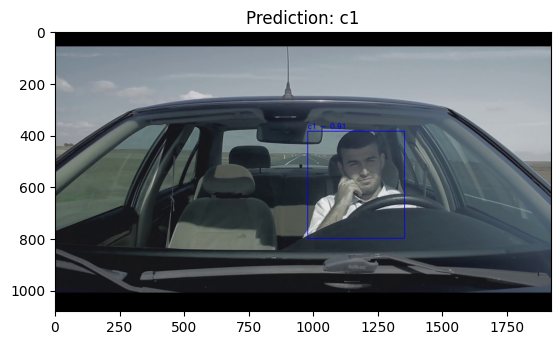

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to detect faces and draw bounding boxes using YOLO
def detect_and_draw_faces_yolo(image, class_name):
    # Load YOLO
    net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
    with open("coco.names", "r") as f:
        classes = [line.strip() for line in f.readlines()]

    # Get the layer names and output layers
    layer_names = net.getUnconnectedOutLayersNames()

    # Convert the image to blob format
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(layer_names)

    # Get the bounding boxes, confidences, and class ids
    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5 and classes[class_id] == "person":  # Assuming person class is used for faces
                center_x = int(detection[0] * image.shape[1])
                center_y = int(detection[1] * image.shape[0])
                w = int(detection[2] * image.shape[1])
                h = int(detection[3] * image.shape[0])
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Choose the bounding box with the highest confidence
    if confidences:
        max_confidence_index = np.argmax(confidences)
        x, y, w, h = boxes[max_confidence_index]

        # Draw bounding box around the detected face
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(image, f"{class_name} - {confidences[max_confidence_index]:.2f}", (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    return image

# Example usage in your code
path1 = '/content/drive/MyDrive/dataset/second/databoom/tsawer/frame_0033.jpg'
img = cv2.imread(path1)

# Assuming 'result' is a tuple (img, predicted_class)
result = predict(path1)

# Extract the predicted class from the result tuple
predicted_class = result[1]
x = 'c' + str(predicted_class)

# Call the detect_and_draw_faces_yolo function to detect and draw bounding boxes around faces
img_with_bbox = detect_and_draw_faces_yolo(img, x)

# Display the image with bounding boxes around faces
plt.title('Prediction: c' + str(predicted_class))
plt.imshow(cv2.cvtColor(img_with_bbox, cv2.COLOR_BGR2RGB))
plt.show()


In [ ]:
import cv2
import numpy as np

# Load YOLO
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Get the layer names and output layers
layer_names = net.getUnconnectedOutLayersNames()

def predict(frame):
    # Resize the frame to the model's input size
    img_resized = cv2.resize(frame, (224, 224), cv2.INTER_LINEAR)

    # Do any preprocessing needed for your model

    # Assuming you have a model that returns predictions
    # Replace the following line with your actual prediction logic
    predicted_class = np.random.randint(0, 5)  # Replace this with your actual prediction logic

    return img_resized, predicted_class

# Create a VideoCapture object
input_video_path = '/content/drive/MyDrive/dataset/second/databoom/ccc.mp4'
cap = cv2.VideoCapture(input_video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# Create a VideoWriter object
output_video_path = '/content/drive/MyDrive/dataset/second/databoom/output_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_video = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

while True:
    # Read a frame from the video
    ret, frame = cap.read()

    # Break the loop if no frame is read
    if not ret:
        break

    # Get the predicted class
    _, predicted_class = predict(frame)

    # Process the frame with face detection using the predicted class as label
    processed_frame = detect_and_draw_faces_yolo(frame, f"c{predicted_class}")

    # Convert processed_frame to BGR for writing to video
    processed_frame_bgr = cv2.cvtColor(processed_frame, cv2.COLOR_RGB2BGR)

    # Write the processed frame to the output video
    output_video.write(processed_frame_bgr)

# Release the VideoCapture and VideoWriter
cap.release()
output_video.release()

print(f"Video created successfully at: {output_video_path}")


Video created successfully at: /content/drive/MyDrive/dataset/second/databoom/output_video.mp4
